In [2]:
%pylab inline
from collections import namedtuple
from pipetools import pipe
from mypy.types import Union

Populating the interactive namespace from numpy and matplotlib


/home/moe/.virtualenvs/sci3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['display', 'Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


IntersectionPoint(location=Point(x=4.6923076923076925, y=-0.5384615384615384), on_l1=True, on_l2=False)


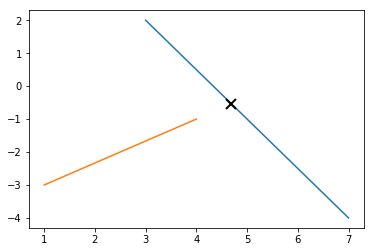

In [3]:
Point = namedtuple('Point', ['x','y'])
ParametricLine = namedtuple('ParametricLine',['p','u'])
Line = namedtuple('Line',['homogenous','parametric'])
class Nowhere(object):pass
class Everywhere(object):pass
IntersectionPoint = namedtuple('IntersectionPoint', ['location','on_l1','on_l2'])
Intersection = Union[Nowhere, Everywhere, IntersectionPoint]


def homogenous_form(p1, p2):
    return np.cross( [p1.x,p1.y,1.0], [p2.x,p2.y,1.0] )

def parametric_form(p1, p2):
    f = np.asfarray
    # Vektor
    u = f([ p2.x-p1.x, p2.y-p1.y ])
    # Fußpunkt
    p = f([ p1.x, p1.y ])
    return ParametricLine(p=p, u=u)

def line_from_endpoints(p1, p2):
    return Line(homogenous=homogenous_form(p1,p2),
                parametric=parametric_form(p1,p2))

def parametric_eval(pf, s):
    return pf.p + (s * pf.u)

def parametric_solve(pf, p: Point) -> float:
    a = np.matrix(pf.u).T
    b = np.matrix([p.x-pf.p[0],p.y-pf.p[1]]).T
    x, residuals, _, _ = np.linalg.lstsq(a, b, rcond=None)
    return x[0,0], residuals[0,0]

def intersection(l1: Line, l2: Line) -> Intersection:
    ix = np.cross(l1.homogenous, l2.homogenous)
    if np.allclose(ix, 0):
        return Everywhere
    if np.allclose(ix[2], 0):
        return Nowhere
    # Now check whether point lies on both lines
    ixp = Point(ix[0]/ix[2], ix[1]/ix[2])
    s1, r1 = parametric_solve(l1.parametric, ixp)
    s2, r2 = parametric_solve(l2.parametric, ixp)
    #print('x, y =', ixp.x, ixp.y)
    #print('s1, r1 =',s1,r1)
    #print('s2, r2 =',s2,r2)
    return IntersectionPoint(location=ixp, on_l1=0<=s1<=1, on_l2=0<=s2<=1)

p1 = Point(3, 2)
p2 = Point(7,-4)
p3 = Point(1,-3)
#p4 = Point(6, 1)
p4 = Point(4, -1)

plot([p1.x,p2.x],[p1.y,p2.y])
plot([p3.x,p4.x],[p3.y,p4.y])

l1 = line_from_endpoints(p1, p2)
l2 = line_from_endpoints(p3, p4)
ix = intersection(l1, l2)
print(ix)
plot(ix.location.x, ix.location.y, 'xk', mew=2, ms=10);

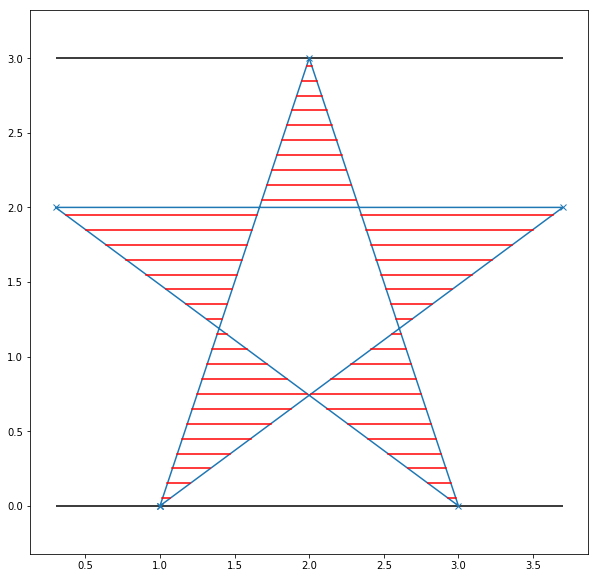

In [56]:
class Polygon(object):
    def __init__(self, xx, yy):
        self.xx = np.asanyarray(xx)
        self.yy = np.asanyarray(yy)
        
    def y_bounds(self):
        return self.yy.min(), self.yy.max()
    
    def lines(self):
        n = len(self.xx)
        for i in range(n):
            idx1 = i % n
            idx2 = (i+1) % n
            p1 = Point(self.xx[idx1], self.yy[idx1])
            p2 = Point(self.xx[idx2], self.yy[idx2])
            yield line_from_endpoints(p1, p2)
        
def display(polygon):
    figure(figsize=(10,10))
    xx = np.hstack([polygon.xx, polygon.xx[0]])
    yy = np.hstack([polygon.yy, polygon.yy[0]])
    plot(xx, yy, 'x-')
    axis('equal')
        
#xx = [5,6,6,5,4,2,3]
#yy = [0,1,4,2,2,4,1]
xx = [1,2,3,0.3,3.7,1]
yy = [0,3,0,2,2,0]
polygon = Polygon(xx, yy)
display(polygon)

y_min, y_max = polygon.y_bounds()
hlines(y_min, min(xx), max(xx))
hlines(y_max, min(xx), max(xx))
alpha = 0.5
y_delta = 0.1

Span = namedtuple('Span', ['x0', 'x1'])

def get_spans(polygon, y):
    scanline = np.cross( (0, y, 1), (1, y, 1) )
    xx = []
    for polyline in polygon.lines():
        ix = np.cross(scanline, polyline.homogenous)
        if ix[2] == 0:
            continue
        ixp = Point(ix[0]/ix[2], ix[1]/ix[2])
        s, _ = parametric_solve(polyline.parametric, ixp)
        if 0 <= s <= 1:
            xx.append( ixp.x )
    xx = sorted(set(xx))
    for a,b in zip(xx[::2],xx[1::2]):
        yield Span(x0=a,x1=b)


for y in np.arange(y_min+alpha*y_delta, y_max, y_delta):
    for span in get_spans(polygon, y):
        plot([span.x0,span.x1],[y,y],'-r')

In [59]:
%%timeit
for y in np.arange(y_min+alpha*y_delta, y_max, y_delta):
    list(get_spans(polygon, y))

49 ms ± 804 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
from polyfill